In [1]:
# Loading libraries

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
import sklearn.linear_model as sk

# Keras import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

from tensorflow.keras import layers
import tensorflow.keras as keras

In [2]:
# Loading data

boston = load_boston()
features = np.array(boston.data)
target = np.array(boston.target)

In [3]:
n_training_samples = features.shape[0]
n_dim = features.shape[1]

print('The dataset has',n_training_samples,'training samples.')
print('The dataset has',n_dim,'features.')

The dataset has 506 training samples.
The dataset has 13 features.


In [4]:
def normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset-mu)/sigma

In [5]:
features_norm = normalize(features)

In [6]:
np.random.seed(42)
rnd = np.random.rand(len(features_norm)) < 0.8

train_x = np.transpose(features_norm[rnd])
train_y = np.transpose(target[rnd])
dev_x = np.transpose(features_norm[~rnd])
dev_y = np.transpose(target[~rnd])

print(train_x.shape)
print(train_y.shape)
print(dev_y.shape)

(13, 399)
(399,)
(107,)


In [7]:
train_y = train_y.reshape(1,len(train_y))
dev_y = dev_y.reshape(1,len(dev_y))

print(train_y.shape)
print(dev_y.shape)

(1, 399)
(1, 107)


In [8]:
# Save the data as files

np.savetxt("boston_train_x.csv", train_x, delimiter=",")
np.savetxt("boston_train_y.csv", train_y, delimiter=",")
np.savetxt("boston_dev_x.csv", dev_x, delimiter=",")
np.savetxt("boston_dev_y.csv", dev_y, delimiter=",")

In [9]:
# Load the Boston dataset from files

train_x = pd.read_csv("boston_train_x.csv", header = None)
train_y = pd.read_csv("boston_train_y.csv", header = None)
dev_x = pd.read_csv("boston_dev_x.csv", header = None)
dev_y = pd.read_csv("boston_dev_y.csv", header = None)

In [10]:
print(train_x.shape)
print(train_y.shape)

(13, 399)
(1, 399)


Now let's look at what happens when we try to do linear regression with a network with 4 layers and each 20 neurons.



In [11]:
tf.keras.backend.clear_session()

In [12]:
class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 1000 == 0: print('Epoch', epoch)

In [13]:
%%time
# Network building Phase
model = tf.keras.Sequential()
model.add(layers.Dense(20, input_dim=13, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
    
model.add(layers.Dense(1, activation='linear')) # Identity activation function

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              metrics=['mse'])

# Training Phase
history = model.fit(train_x.transpose(), train_y.transpose(), epochs=10000, 
          batch_size=train_x.shape[1],verbose = 0,
          callbacks=[PrintProgress()])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 0
Epoch 1000
Epoch 2000
Epoch 3000
Epoch 4000
Epoch 5000
Epoch 6000
Epoch 7000
Epoch 8000
Epoch 9000
Wall time: 58.4 s


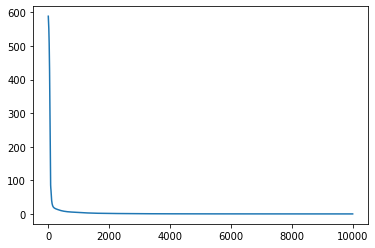

In [14]:
# Quick plot of the MSE
plt.plot(history.history['mean_squared_error'])

In [15]:
history.history['mean_squared_error'][-1]

0.05733907

In [16]:
ynew = model.predict(dev_x.transpose())

In [17]:
np.mean(np.square(ynew-dev_y.T))

0    30.767039
dtype: float64

### Regularization L2

In [18]:
tf.keras.backend.clear_session()

In [19]:
%%time
# Network building Phase
model = tf.keras.Sequential()
model.add(layers.Dense(20, input_dim=13, activation='relu', kernel_regularizer=regularizers.l2(10.0)))
model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(10.0)))
model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(10.0)))
model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(5.0)))
    
model.add(layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.0125))) # Identity activation function

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              metrics=['mse'])

# Training Phase
history = model.fit(train_x.transpose(), train_y.transpose(), epochs=5000, 
          batch_size=train_x.shape[1],verbose = 0,
          callbacks=[PrintProgress()])

Epoch 0
Epoch 1000
Epoch 2000
Epoch 3000
Epoch 4000
Wall time: 32.4 s


In [20]:
history.history['mean_squared_error'][-1]

21.026083

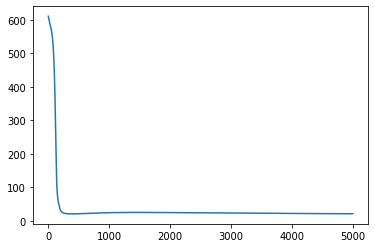

In [21]:
plt.plot(history.history['mean_squared_error'])

In [22]:
ynew = model.predict(dev_x.transpose())

In [23]:
np.mean(np.square(ynew-dev_y.T))

0    20.500026
dtype: float64